# Калибровка вероятностей

Иногда в задаче классификации важно знать уверенность отнесения к тому или иному классу. В SVM за это отвечает параметр отступа model.decision_function(X). Однако по нему сложно утверждать с какой вероятностью объект относится к тому или иному классу.

Чтобы это понять давайте визуализируем, как соотносится сортировка объектов по отступам с сортировкой
по таргету (классу). То есть построим кривую, в которой по оси X - доля выборки с отступом, меньшим чем данный,
по оси Y - доля объектов класса 1 с отступом, меньшим чем данный среди всех объектов класса 1.   

In [1]:
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import numpy as np
import matplotlib.pyplot as plt

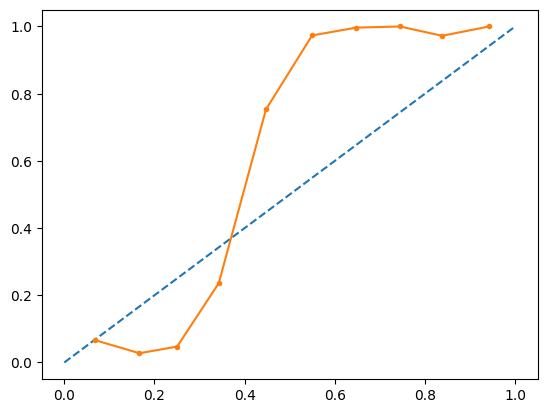

In [2]:
# generate 2 class dataset
X, y = make_classification(n_samples=5000, n_classes=2, weights=[1,1], random_state=1)

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

# fit a model
model = SVC()
model.fit(trainX, trainy)

# predict probabilities
probs = model.decision_function(testX)

# Normalize probabilities
probs_normalized = (probs - probs.min()) / (probs.max() - probs.min())

# reliability diagram
fop, mpv = calibration_curve(testy, probs_normalized, n_bins=10)

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')

# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Вот мы и увидели проблему, линия отступов не ложится на пунктирную линию, что означает что оступы не соотвествуют реальным вероятностям отнесения к тому или иному классу.  

   Для этого существует такая процедура как калибровка вероятностей, при которой отступ для каждого объекта преобразовывается таким образом, чтобы соответствовать вероятности класса. После такого преобразования, полученное число становится интерпретируемой мерой уверенности модели. 

В данном задании Вам прелагается обучить логистическую регрессию на отступах модели, которая по оступу предсказывала бы класс. Именно вероятности этой калибровочной модели и будут нашими верными оценками вероятности класса для объекта:

$p(y_i | x_i) = p(y_i | margin_i)$

Для этого Вам потребуется написать несложный класс CalibratingLogisticRegression. И проверить что новые предсказания дают правильную калибровочную кривую

In [3]:
class CalibratingLogisticRegression:
    def __init__(self):
        self.model = LogisticRegression()
        
    def fit(self, x, y):
        assert len(x.shape) == 1 or x.shape[1] == 1
        self.model.fit(x, y)
        
    def predict_proba(self, x):
        assert len(x.shape) == 1 or x.shape[1] == 1
        return self.model.predict_proba(x.reshape(-1, 1))[:, 1]

Калибровочную модель и исходную модель нельзя учить на одних и тех же данных, чтобы избежать переобучения. (распределение отступов на обучении и тестовой выборке, скорее всего очень сильно отличается)

In [4]:
model = SVC()
N = len(trainX) // 2
model.fit(trainX[:N], trainy[:N])

SVC()

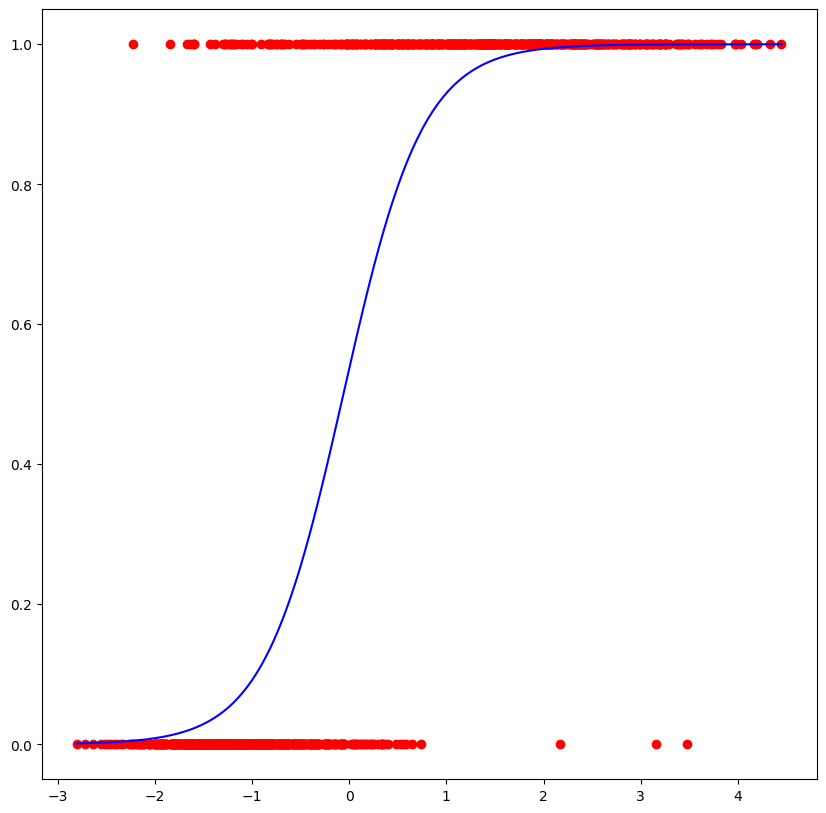

In [5]:
# Получаем отступы для второй половины данных
margin = model.decision_function(trainX[N:])
X_features_for_calibrating_model = margin.reshape(-1, 1)

# Учим калибровочную модель на второй половине данных
calibrating_model = CalibratingLogisticRegression()
calibrating_model.fit(X_features_for_calibrating_model, trainy[N:])
prob = calibrating_model.predict_proba(margin)

# Как это выглядит на обучении
margin_sorted, probs_sorted_by_margin = zip(*sorted(zip(margin, prob)))
plt.figure(figsize=(10, 10))
plt.plot(margin, trainy[N:], 'ro')
plt.plot(margin_sorted, probs_sorted_by_margin, 'b')
plt.show()

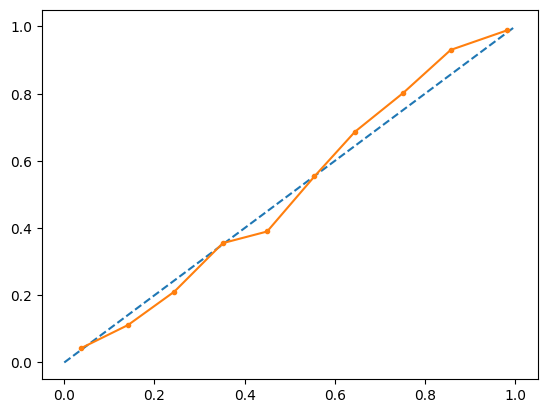

In [22]:
probs = calibrating_model.predict_proba(model.decision_function(testX))

# Normalize probabilities
probs_normalized = (probs - probs.min()) / (probs.max() - probs.min())

# reliability diagram
fop, mpv = calibration_curve(testy, probs, n_bins=10)
# fop, mpv = calibration_curve(testy, probs_normalized, n_bins=10)

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')

# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()